In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

In [3]:
data = pd.read_csv('D:\\financial_time_series\\bitcoin_price_history.csv', parse_dates=['startTime'])

In [4]:
data['startTime'] = pd.to_datetime(data['startTime'])
data.set_index('startTime', inplace=True)

In [5]:
data.sort_index(inplace=True)

In [6]:
def create_features(df):
    df['lag1'] = df['closePrice'].shift(1)
    df['lag2'] = df['closePrice'].shift(2)
    df['lag3'] = df['closePrice'].shift(3)
    df['rolling_mean'] = df['closePrice'].rolling(window=5).mean()
    df['rolling_std'] = df['closePrice'].rolling(window=5).std()
    df['volume_rolling_mean'] = df['volume'].rolling(window=5).mean()
    df['turnover_rolling_mean'] = df['turnover'].rolling(window=5).mean()

    df = df.dropna()

    return df

In [7]:
data = create_features(data)

In [8]:
X = data[['lag1', 'lag2', 'lag3', 'rolling_mean', 'rolling_std', 'volume_rolling_mean', 'turnover_rolling_mean']]
y = data['closePrice']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [10]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

D:\financial_time_series\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
y_pred = model.predict(X_test)

In [12]:
mse = mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error (MSE): {mse}')

Root Mean Squared Error (MSE): 6577975.7163732005


In [17]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 3.86%


In [14]:
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

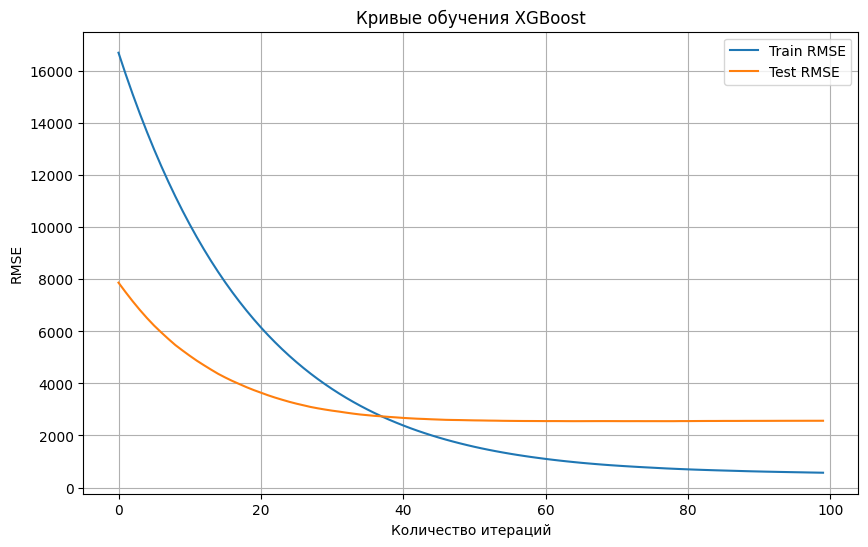

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train RMSE')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test RMSE')
plt.legend()
plt.ylabel('RMSE')
plt.title('Кривые обучения XGBoost')
plt.xlabel('Количество итераций')
plt.grid(True)
plt.show()

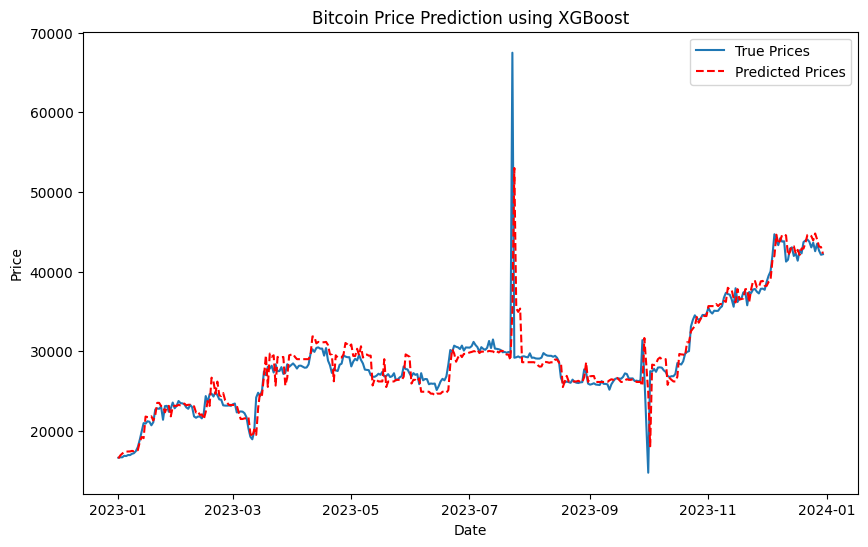

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Prices')
plt.plot(y_test.index, y_pred, label='Predicted Prices', linestyle='--', color='red')
plt.legend()
plt.title('Bitcoin Price Prediction using XGBoost')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()